In [1]:
import cdsapi
import os
import xarray as xr
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path

In [19]:
os.getcwd()

'/home/pat6/module_4/ATMS-523-Module-4-Trierweiler'

In [ ]:
# download data
# sea_surface temperature,Total water column vapor, land_sea_mask
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "sea_surface_temperature",
        "total_column_water_vapour",
        "land_sea_mask"
    ],
    "year": [
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [65, 120, -65, -60]
}

client = cdsapi.Client()
client.retrieve(dataset, request,'module_4_HW_data.nc')

In [2]:
ds = xr.load_dataset('module_4_HW_data.nc')
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    sst         (valid_time, latitude, longitude) float32 829MB nan nan ... nan
    tcwv        (valid_time, latitude, longitude) float32 829MB 1.102 ... 7.988
    lsm         (valid_time, latitude, longitude) float32 829MB 0.9839 ... 0....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-17T23:56 GRIB to CDM+CF via cfgrib-0.9.1...

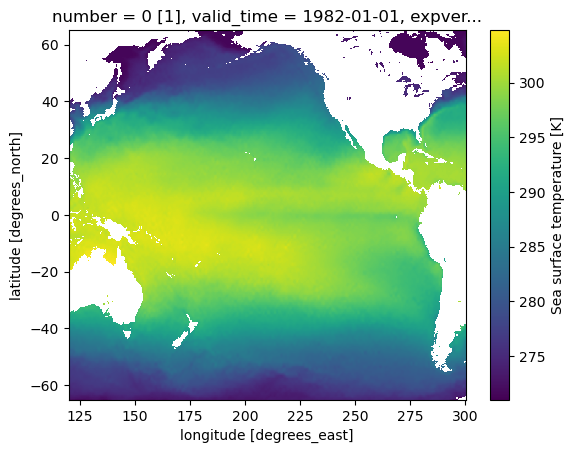

In [3]:
ds['sst'].sel(valid_time='1982-01-01').plot()

In [5]:
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")


def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)


def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

In [6]:
# detrend the data
detr = linear_detrend(ds[["sst", "tcwv"]], time_dim="valid_time")

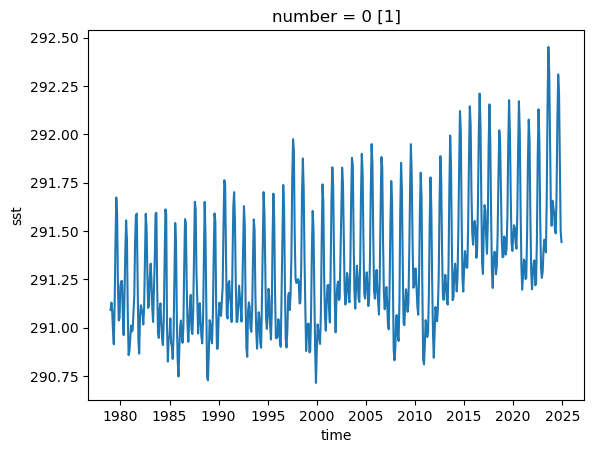

In [7]:
ds['sst'].mean(dim=('latitude','longitude')).plot()

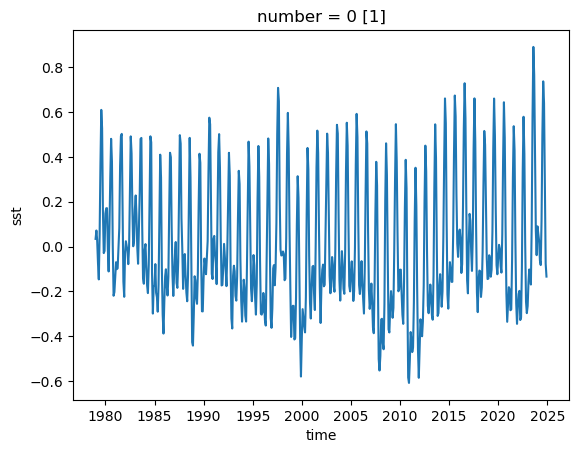

In [8]:
detr['sst'].mean(dim=('latitude','longitude')).plot()

In [9]:
# calculat anomaly
anom, z = monthly_anom_and_z(detr, time_dim="valid_time")

/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var =

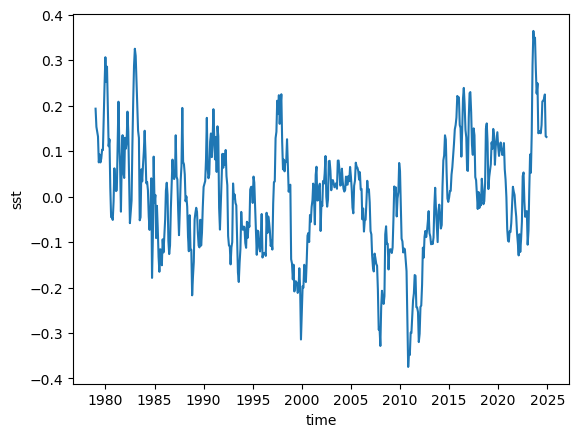

In [9]:
anom['sst'].mean(dim=('latitude','longitude')).plot()

In [11]:
sst = anom['sst']
sst = sst.rename({"valid_time": "time"})
# sst = sst.drop_vars('number')
# sst = sst.drop_vars('month')
# sst = sst.drop_vars('expver')

In [12]:
sst

<xarray.DataArray 'sst' (time: 552, latitude: 521, longitude: 721)> Size: 829MB
array([[[        nan,         nan,         nan, ...,  0.309691  ,
          0.3044023 ,  0.29929042],
        [        nan,         nan,         nan, ...,  0.28573346,
          0.27527618,  0.26306403],
        [        nan,         nan,         nan, ...,  0.30389512,
          0.2848041 ,  0.26580334],
        ...,
        [-0.2634915 , -0.26016426, -0.25721997, ...,         nan,
                 nan,         nan],
        [-0.8167715 , -0.7999257 , -0.7836324 , ...,         nan,
                 nan,         nan],
        [-0.77200663, -0.7685803 , -0.7792716 , ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.31713736,
          0.31656146,  0.3160777 ],
        [        nan,         nan,         nan, ...,  0.2979988 ,
          0.29363453,  0.2868359 ],
        [        nan,         nan,         nan, ...,  0.3199606 ,
          0.30577338,  0.29159212],
...
        [-0.06360531, -0.07058424, -0.07768965, ...,         nan,
                 nan,         nan],
        [-0.052912  , -0.05818784, -0.06344137, ...,         nan,
                 nan,         nan],
        [-0.08525869, -0.08921582, -0.09192052, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -0.24171853,
         -0.21872425, -0.19556725],
        [        nan,         nan,         nan, ..., -0.17914379,
         -0.16996014, -0.16122937],
        [        nan,         nan,         nan, ..., -0.20193422,
         -0.1951133 , -0.18904114],
        ...,
        [ 0.3747598 ,  0.3342593 ,  0.29373848, ...,         nan,
                 nan,         nan],
        [ 0.42111886,  0.39499554,  0.36908546, ...,         nan,
                 nan,         nan],
        [ 0.2672326 ,  0.26641747,  0.2920543 , ...,         nan,
                 nan,         nan]]], shape=(552, 521, 721), dtype=float32)
Coordinates:
    number     (time) int64 4kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-12-01
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    expver     (time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001' '0001'
    month      (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

In [13]:
# creating the weights and creating the solver
coslat = np.cos(np.deg2rad(sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]


In [14]:
solver = Eof(sst, weights=wgts)

In [16]:
eof1 = solver.eofsAsCorrelation(neofs=5)
pc1 = solver.pcs(npcs=5, pcscaling=1)

/home/pat6/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Text(0.5, 1.0, 'EOF1 expressed as correlation')

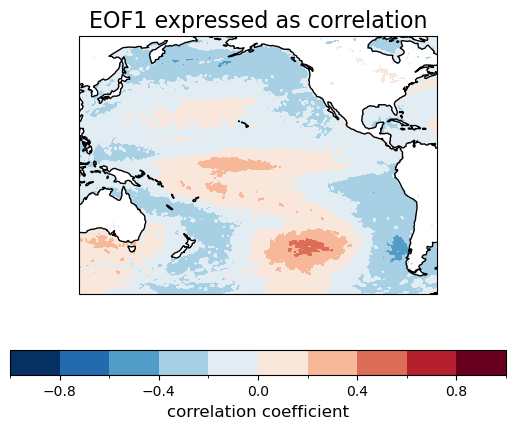

In [18]:
#plot a map of the first 5 EOF
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[4].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 expressed as correlation', fontsize=16)